**Imports and Installations**

In [190]:
%%capture --no-stderr
%pip install -U langgraph langsmith langchain_anthropic datasets langchain langchainhub
%pip install --upgrade --quiet  rank_bm25
%pip install -qU langchain-openai

In [191]:
import getpass
import os
import zipfile
import datasets
import requests
import re
import multiprocessing
import queue
import subprocess
import sys
import time
import traceback

from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import AnyMessage, add_messages
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage
from langchain_core.language_models import BaseChatModel
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from langchain import hub
from langchain_anthropic import ChatAnthropic
from langchain_community.retrievers import BM25Retriever
from langchain_core.runnables import RunnableConfig
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph, START
from langchain_core.tracers.context import tracing_v2_enabled
from langsmith import Client
from langchain_openai import ChatOpenAI

**Set up API Keys and LangSmith tracing**

In [192]:
def _get_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_get_env("OPENAI_API_KEY")
_get_env("LANGCHAIN_API_KEY")
_get_env("ANTHROPIC_API_KEY")

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "usacoV2"

**Get the USACO dataset**

In [193]:
usaco_url = "https://storage.googleapis.com/benchmarks-artifacts/usaco/usaco_sampled_with_tests.zip"
zip_path = "usaco.zip"
extract_path = "usaco_datasets"

response = requests.get(usaco_url)
with open(zip_path, "wb") as file:
    file.write(response.content)

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_path)

os.remove(zip_path)

#ds = datasets.load_from_disk(os.path.join(extract_path, "usaco_v3_sampled_with_tests"))
ds = datasets.load_from_disk("/Users/stevenyu/codeSheepcode/usaco_data/datasets/usaco_v3")

**filter_python_code**: Gets a python-only output from an LLM raw output (mainly used for GPT-4)

In [121]:
def filter_python_code(output: str) -> str:
    """
    Filters the model's output to extract only the Python code contained within ```python and ``` delimiters.
    
    Parameters:
        output (str): The raw output from the model.

    Returns:
        str: Filtered output containing only the Python code.
    """
    # Locate code block between ```python and ```
    code_block = re.search(r"```python(.*?)```", output, re.DOTALL)
    
    # If code block is found, return the content; otherwise, return an empty string
    if code_block:
        return code_block.group(1).strip()
    else:
        return output

**exec_program**: Function for running local code

**check_correctness**: Function for checking correctness of code output

**Sets timeout to 2 seconds**

In [122]:
multiprocessing.set_start_method("fork", force=True)
# WARNING
# This program exists to execute untrusted model-generated code. Although
# it is highly unlikely that model-generated code will do something overtly
# malicious in response to this test suite, model-generated code may act
# destructively due to a lack of model capability or alignment.
# Users are strongly encouraged to sandbox this evaluation suite so that it
# does not perform destructive actions on their host or network.
# Proceed at your own risk:


def exec_program(q, program, input_data, expected_output, timeout):
    try:
        start_time = time.time()
        process = subprocess.Popen(
            [sys.executable, "-c", program],
            stdin=subprocess.PIPE,
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            text=True,
        )
        stdout, stderr = process.communicate(input=input_data, timeout=timeout)
        if time.time() - start_time > timeout:
            raise TimeoutError("Execution timed out.")
        if process.returncode != 0:
            q.put(f"failed: {stderr}")
        else:
            if stdout.strip() == expected_output.strip():
                q.put("passed")
            else:
                q.put(f"wrong answer. Expected '{expected_output}', got '{stdout}'")
    except subprocess.TimeoutExpired:
        process.kill()
        q.put("timed out")
    except Exception:
        q.put(f"failed: {traceback.format_exc()}")


def check_correctness(
    program: str, input_data: str, expected_output: str, timeout: float
) -> str:
    filtered_program = filter_python_code(program)
    q = multiprocessing.Queue()
    process = multiprocessing.Process(
        target=exec_program, args=(q, program, input_data, expected_output, timeout)
    )
    process.start()
    process.join(timeout=timeout + 1)
    if process.is_alive():
        process.terminate()
        process.join()
        result = "timed out"
    else:
        try:
            result = q.get_nowait()
        except queue.Empty:
            result = "no result returned"
    return result

timeout = 2

**State for each example in the dataset**

In [123]:
input_states = [
    {
        "messages": [("user", row["description"])],
        "test_cases": row["test_cases"],
        "runtime_limit": row["runtime_limit"],
        "status": "in_progress",
        "problem_level": row["problem_level"],
    }
    for row in ds
]

KeyError: 'test_cases'

**TestCase**: Class for test cases

**State**: Class for states of the graph

In [124]:
class TestCase(TypedDict):
    inputs: str
    outputs: str


class State(TypedDict):
    # Candidate for retrieval + formatted fetched examples as "memory"
    candidate: AIMessage
    examples: str
    messages: Annotated[list[AnyMessage], add_messages]
    test_cases: list[TestCase]
    runtime_limit: int
    status: str

**format_tool_message**: formats raw output of Claude

**evaluate**: Checks if the LM's code passes the test cases

In [125]:
def format_tool_message(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response + "\nMake all fixes using the writePython tool.",
        tool_call_id=ai_message.tool_calls[0]["id"],
    )

def evaluate(state: State):
    test_cases = state["test_cases"]
    ai_message: AIMessage = state["messages"][-1]
    if not ai_message.tool_calls:
        return {
            "messages": [
                HumanMessage(
                    content="No code submitted. Please try again using the correct python code."
                )
            ]
        }
    try:
        code = ai_message.tool_calls[0]["args"]["code"]
    except Exception as e:
        return {"messages": [format_tool_message(repr(e), ai_message)]}
    num_test_cases = len(test_cases)
    succeeded = 0
    test_results = []
    # TODO: Multiprocess
    for test_case in test_cases:
        input_data = test_case["inputs"]
        expected_output = test_case["outputs"]
        test_result = check_correctness(code, input_data, expected_output, timeout)
        test_results.append(test_result)
        if test_result == "passed":
            succeeded += 1
    pass_rate = succeeded / num_test_cases if num_test_cases else "N/A"
    if pass_rate == 1:
        return {"status": "success"}

    responses = "\n".join(
        [f"<test id={i}>\n{r}\n</test>" for i, r in enumerate(test_results)]
    )
    response = f"Incorrect submission. Please respond with updated code.\nPass rate: {succeeded}/{num_test_cases}\nResults:\n{responses}"
    formatted_message = format_tool_message(response, ai_message)
    return {"messages": [formatted_message]}

**writePython**: Gives the LM a specific format to generate the solution code

**Solver**: Special class that uses its LM to answer a given prompt

In [170]:
class writePython(BaseModel):
    """Write python code that resolves the problem."""

    reasoning: str = Field(..., description="Conceptual solution.")
    pseudocode: str = Field(..., description="Detailed English pseudocode.")
    code: str = Field(..., description="Valid Python 3 solution to the problem")

class modifyPython(BaseModel):
    """Modifies existing code"""

    analysis: str = Field(..., description="Analysis of previous attempt.")
    code: str = Field(..., description="Improved Python 3 solution to the problem")


class Solver:
    def __init__(self, llm: BaseChatModel, prompt: ChatPromptTemplate):
        self.runnable = prompt | llm.bind_tools([writePython], tool_choice="writePython")

    def __call__(self, state: State) -> dict:
        # Our agent only can see the "messages" and will ignore the test info
        inputs = {"messages": state["messages"]}
        has_examples = bool(state.get("examples"))
        output_key = "candidate"  # Used in the draft node
        if has_examples:
            output_key = "messages"
            # Used in the solve node
            inputs["examples"] = state["examples"]
        response = self.runnable.invoke(inputs)
        return {output_key: response}

class Modifier:
    def __init__(self, llm: BaseChatModel):
        self.runnable = llm.bind_tools([modifyPython], tool_choice="modifyPython")

    def __call__(self, state: State) -> dict:
        # Extract the last AI message which should contain the code to evaluate
        ai_message: AIMessage = state["messages"][-1]
        test_cases = state["test_cases"]

        # Extract code from the message
        code = None
        if not ai_message.tool_calls:
            filtered_code = filter_python_code(ai_message.content)
            if not filtered_code:
                return {
                    "messages": [
                        HumanMessage(
                            content="No evaluatable code found in the submission. Please provide valid Python code."
                        )
                    ],
                    "status": "invalid_submission"
                }
            code = filtered_code
        else:
            try:
                if "code" in ai_message.tool_calls[0]["args"]:
                    code = ai_message.tool_calls[0]["args"]["code"]
                else:
                    raise ValueError("No code found in tool arguments.")
            except Exception as e:
                return {
                    "messages": [format_tool_message(repr(e), ai_message)],
                    "status": "error"
                }
            
        num_test_cases = len(test_cases)
        succeeded = 0
        test_results = []
        # TODO: Multiprocess
        for test_case in test_cases:
            input_data = test_case["inputs"]
            expected_output = test_case["outputs"]
            test_result = check_correctness(code, input_data, expected_output, timeout)
            test_results.append(test_result)
            if test_result == "passed":
                succeeded += 1
        pass_rate = succeeded / num_test_cases if num_test_cases else "N/A"
        if pass_rate == 1:
            return {"status": "success"}

        responses = "\n".join(
            [f"<test id={i}>\n{r}\n</test>" for i, r in enumerate(test_results)]
        )
        
        problem = state["messages"][0]
        
        response = self.runnable.invoke("""Write an analysis of the previous attempt based on the problem, code, and test case results, and create a modified version of the code.\n
        Problem: {problem}\n\n
        Code: {code}\n\n
        Test Case Results: {responses}
        """.format(problem=problem, code=code, responses=responses))

        return {"messages": response}
        

class Evaluator:
    def __init__(self, llm: BaseChatModel):
        self.llm = llm

    def __call__(self, state: State) -> dict:
        # Our agent only can see the "messages" and will ignore the test info
        """
        Evaluates code submitted by another LLM against test cases.
        
        Args:
            state (State): Contains messages, test cases, and optional examples
            
        """
        # Extract the last AI message which should contain the code to evaluate
        ai_message: AIMessage = state["messages"][-1]
        test_cases = state["test_cases"]

        # Extract code from the message
        code = None
        if not ai_message.tool_calls:
            filtered_code = filter_python_code(ai_message.content)
            if not filtered_code:
                return {
                    "messages": [
                        HumanMessage(
                            content="No evaluatable code found in the submission. Please provide valid Python code."
                        )
                    ],
                    "status": "invalid_submission"
                }
            code = filtered_code
        else:
            try:
                if "code" in ai_message.tool_calls[0]["args"]:
                    code = ai_message.tool_calls[0]["args"]["code"]
                else:
                    raise ValueError("No code found in tool arguments.")
            except Exception as e:
                return {
                    "messages": [format_tool_message(repr(e), ai_message)],
                    "status": "error"
                }
            
        num_test_cases = len(test_cases)
        succeeded = 0
        test_results = []
        # TODO: Multiprocess
        for test_case in test_cases:
            input_data = test_case["inputs"]
            expected_output = test_case["outputs"]
            test_result = check_correctness(code, input_data, expected_output, timeout)
            test_results.append(test_result)
            if test_result == "passed":
                succeeded += 1
        pass_rate = succeeded / num_test_cases if num_test_cases else "N/A"
        if pass_rate == 1:
            return {"status": "success"}

        responses = "\n".join(
            [f"<test id={i}>\n{r}\n</test>" for i, r in enumerate(test_results)]
        )
        
        problem = state["messages"][0]
        
        analysis = self.llm.invoke("""Write an analysis of the previous attempt based on the problem, code, and test case results, and create a modified version of the code.\n
        Problem: {problem}\n\n
        Code: {code}\n\n
        Test Case Results: {responses}
        """.format(problem=problem, code=code, responses=responses))

        response = f"The previous submission failed at least one test case either by error or timeout. Please respond with updated code.\nPass rate: {succeeded}/{num_test_cases}\nResults:\n{responses}\nAnalysis:\n{analysis}"
        formatted_message = format_tool_message(response, ai_message)

        return {"messages": [formatted_message]}

**1. Sets the following prompt:**

================================ System Message ================================

You are a world-class competitive programmer.
Please reply with a Python 3 solution to the problem below. 
First, reason through the problem and conceptualize a solution.
Then write detailed pseudocode to uncover any potential logical errors or omissions.
Finally output the working Python code for your solution, ensuring to fix any errors uncovered while writing pseudocode.

No outside libraries are allowed.{examples}

============================= Messages Placeholder =============================

{messages}

**2. Sets the LM to Claude 3 Opus**

**3. Creates a solver and draft solver**

In [171]:
prompt = hub.pull("wfh/usaco-draft-solver")
llm_claude = ChatAnthropic(model="claude-3-opus-20240229", max_tokens = 4096)
llm_openai = ChatOpenAI(model="gpt-4o") 

draft_solver = Solver(llm_claude, prompt.partial(examples=""))
solver = Solver(llm_openai, prompt)
modifier = Modifier(llm_claude)

**format_example**: Formats each problem in the dataset so that the retriever can handle it

**retriever**: Uses BM25 to find the best examples of code for the LM to use

In [161]:
def format_example(row):
    question = row["description"]
    answer = row["solution"]
    return f"""<problem>
{question}
</problem>
<solution>
{answer}
</solution>"""

**retrieve_examples**: Function that finds the most relevant previous problems from episodic memory based on the current State of the graph, including a draft code and the input problem

In [162]:
def retrieve_examples(state: State, config: RunnableConfig):
    top_k = config["configurable"].get("k") or 2
    ai_message: AIMessage = state["candidate"]
    id = config["configurable"].get("thread_id")

    test_ds = [row for row in ds if row["cp_id"] != id]
    retriever = BM25Retriever.from_texts([format_example(row) for row in test_ds])
    
    if not ai_message.tool_calls:
        # We err here. To make more robust, you could loop back
        raise ValueError("Draft agent did not produce a valid code block")
    code = ai_message.tool_calls[0]["args"]["code"]
    examples_str = "\n".join(
        [doc.page_content for doc in retriever.invoke(code)[:top_k]]
    )
    examples_str = f"""
You previously solved the following problems in this competition:
<Examples>
{examples_str}
<Examples>
Approach this new question with similar sophistication."""
    return {"examples": examples_str}

**Builds the graph and adds an interrupt for human feedback**

In [183]:
builder = StateGraph(State)

builder.add_node("draft", draft_solver)
builder.add_edge(START, "draft")
builder.add_node("retrieve", retrieve_examples)
builder.add_node("solve", solver)
builder.add_node("modify",modifier)
builder.add_node("evaluate", evaluate)
builder.add_edge("draft", "retrieve")
builder.add_edge("retrieve", "solve")
#builder.add_edge("solve", "modify")
#builder.add_edge("modify", "evaluate")
builder.add_edge("solve","evaluate")


def control_edge(state: State):
    if state.get("status") == "success":
        return END
    return "solve"


builder.add_conditional_edges("evaluate", control_edge, {END: END, "solve": "solve"})
checkpointer = MemorySaver()

graph = builder.compile(
    checkpointer=checkpointer,
    # New: this tells the graph to break any time it goes to the "human" node
    interrupt_after=["evaluate"],
)

**Graph visualization**

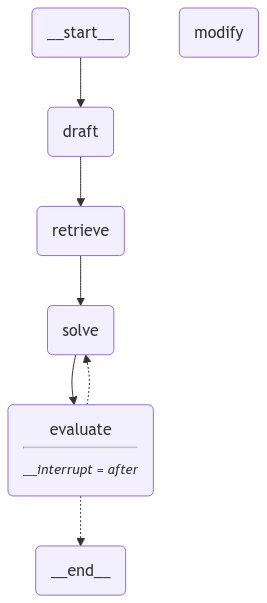

In [184]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

**Removes huge test cases from input to save memory and tokens**

In [185]:
def _hide_test_cases(inputs):
    copied = inputs.copy()
    if "test_cases" in copied:
        copied["test_cases"] = [
            {
                "inputs": "..." if len(tc["inputs"]) > 200 else tc["inputs"],
                "outputs": "..." if len(tc["outputs"]) > 200 else tc["outputs"]
            }
            for tc in copied["test_cases"]
        ]
    else:
        copied["test_cases"] = "..."
    return copied

**Runs the code based on input**

In [186]:
#indices of problems at each level
levels = [[9, 10, 11, 21, 22, 23, 33, 34, 35, 45, 46, 47, 57, 58, 59, 69, 70, 71, 81, 82, 83, 93, 94, 95, 105, 106, 107, 117, 118, 119, 129, 130, 131, 141, 142, 143, 153, 154, 155, 165, 166, 167, 177, 178, 179, 189, 190, 191, 200, 201, 202, 212, 213, 214, 224, 225, 226, 236, 237, 238, 248, 249, 250, 260, 261, 262, 272, 273, 274, 284, 285, 286, 295, 296, 297, 307, 308, 309, 315, 316, 317, 318, 325, 326, 327, 334, 335, 336, 343, 344, 345, 352, 353, 354, 361, 362, 363, 370, 371, 372, 379, 380, 381, 382, 389, 390, 391, 398, 399, 400, 407, 408, 409, 416, 417, 418, 425, 426, 427, 434, 435, 436, 437, 444, 445, 446, 453, 454, 455, 462, 463, 464, 471, 472, 473, 480, 481, 482, 483, 493, 494, 495, 505, 506, 507, 517, 518, 519],
            [6, 7, 8, 18, 19, 20, 30, 31, 32, 42, 43, 44, 54, 55, 56, 66, 67, 68, 78, 79, 80, 90, 91, 92, 102, 103, 104, 114, 115, 116, 126, 127, 128, 138, 139, 140, 150, 151, 152, 162, 163, 164, 174, 175, 176, 186, 187, 188, 197, 198, 199, 209, 210, 211, 221, 222, 223, 233, 234, 235, 245, 246, 247, 257, 258, 259, 269, 270, 271, 281, 282, 283, 292, 293, 294, 304, 305, 306, 312, 313, 314, 322, 323, 324, 331, 332, 333, 340, 341, 342, 349, 350, 351, 358, 359, 360, 367, 368, 369, 376, 377, 378, 386, 387, 388, 395, 396, 397, 404, 405, 406, 413, 414, 415, 422, 423, 424, 431, 432, 433, 441, 442, 443, 450, 451, 452, 459, 460, 461, 468, 469, 470, 477, 478, 479, 490, 491, 492, 502, 503, 504, 514, 515, 516], 
            [3, 4, 5, 15, 16, 17, 27, 28, 29, 39, 40, 41, 51, 52, 53, 63, 64, 65, 75, 76, 77, 87, 88, 89, 99, 100, 101, 111, 112, 113, 123, 124, 125, 135, 136, 137, 147, 148, 149, 159, 160, 161, 171, 172, 173, 183, 184, 185, 194, 195, 196, 206, 207, 208, 218, 219, 220, 230, 231, 232, 242, 243, 244, 254, 255, 256, 266, 267, 268, 278, 279, 280, 290, 291, 301, 302, 303, 310, 311, 319, 320, 321, 328, 329, 330, 337, 338, 339, 346, 347, 348, 355, 356, 357, 364, 365, 366, 373, 374, 375, 383, 384, 385, 392, 393, 394, 401, 402, 403, 410, 411, 412, 419, 420, 421, 428, 429, 430, 438, 439, 440, 447, 448, 449, 456, 457, 458, 465, 466, 467, 474, 475, 476, 487, 488, 489, 499, 500, 501, 511, 512, 513], 
            [0, 1, 2, 12, 13, 14, 24, 25, 26, 36, 37, 38, 48, 49, 50, 60, 61, 62, 72, 73, 74, 84, 85, 86, 96, 97, 98, 108, 109, 110, 120, 121, 122, 132, 133, 134, 144, 145, 146, 156, 157, 158, 168, 169, 170, 180, 181, 182, 192, 193, 203, 204, 205, 215, 216, 217, 227, 228, 229, 239, 240, 241, 251, 252, 253, 263, 264, 265, 275, 276, 277, 287, 288, 289, 298, 299, 300, 484, 485, 486, 496, 497, 498, 508, 509, 510]]
#148 bronze
#144 silver
#142 gold
#086 platinum
#520 total

def get_problem_ds(problem):
    test_path = "/Users/stevenyu/codeSheepcode/usaco_data/datasets/usaco_v3/tests/" + problem["cp_id"] + "/"
    test_cases = []
    for i in range(int(problem["num_tests"])):
        test_cases.append({"inputs":"", "outputs":""})
        inFN = test_path + "I." + str(i+1)
        outFN = test_path + "O." + str(i+1)
        with open(inFN, "r") as file:
            test_cases[i]["inputs"] = file.read()
        with open(outFN, "r") as file:
            test_cases[i]["outputs"] = file.read()
    return {
        "title": problem["cp_id"],
        "messages": [("user", problem["description"])],
        "test_cases": test_cases,
        "runtime_limit": problem["runtime_limit"],
        "status": "in_progress",
    }

client = Client(hide_inputs=_hide_test_cases, hide_outputs=_hide_test_cases)

def solve_no_interrupt(trials, problem):
    '''Runs the solver 'trials' times without human feedback'''

    config = {"configurable": {"thread_id": problem["title"], "k": 2}}
    

    def concat_test_case(s: str):
        print(s[:133])

        pattern = r"<test id=\d+>(.*?)</test>"
        # Find all matches
        matches = re.findall(pattern, s, re.DOTALL)

        # Print a few characters from each test case
        for i, match in enumerate(matches, start=1):
            print(f"Test Case {i}:\n {match[:50]}...") 

    def display_diagnostic():

        most_recent_state = list(graph.get_state_history(config))[0]
        snapshot = graph.get_state(most_recent_state.config)
        ai_message = snapshot.values["messages"][-2]
        print("*" * 35 + " Previous Attempt Diagnostic " + "*" * 35)
        print("\n\nThought Process:\n\n")
        if ai_message.content:
            print(ai_message.content)
        print("\n\nCode:\n\n")
        if hasattr(ai_message, "tool_calls") and ai_message.tool_calls:
            print(ai_message.tool_calls[0]["args"]["code"])
        else:
            print(filter_python_code(ai_message.content))
        print("\n\nTest Case Results:\n\n")
        concat_test_case(snapshot.values["messages"][-1].content)

    #Runs the solver num_trials times
    def run_solver(stream_state, num_trials, new_config):
        with tracing_v2_enabled(client=client):
            for _ in range(num_trials):
                events = graph.stream(stream_state, new_config)
                for event in events:
                    for value in event.values():
                        if type(value) == tuple:
                            continue
                        messages = value.get("messages")
                        if messages:
                            if isinstance(messages, list):
                                messages = value["messages"][-1]
                            print(
                                "Assistant:",
                                str(messages.content).replace("\n", "\\n")[:50],
                            )
                        elif value.get("examples"):
                            print("Retrieved examples:\n\n", value["examples"][:300] + "...")
                        elif value.get("candidate"):
                            print(str(value["candidate"].content)[:200])
                most_recent_state = list(graph.get_state_history(config))[0]
                snapshot = graph.get_state(most_recent_state.config)
                print(snapshot.values["messages"][-1].content[:133])
                if graph.get_state(config).values["status"] == "success":
                    print("Code successful.")
                    display_diagnostic()
                    return ""

    run_solver(problem, 1, config) #first iteration
    if graph.get_state(config).values["status"] != "success":
        run_solver(None, trials-1, config) #other trials-1 iterations
        display_diagnostic()

    return graph.get_state(config).values["status"]

In [187]:
graph.stream(None)

<generator object Pregel.stream at 0x316caa3e0>

In [189]:
#Sample of 4 problems of each difficulty
sample = [[9,102,125],
          [8,9,82],
          [35,79,131],
          [6,29,62]]
 
row = ds[levels[1][8]]
print(row["description"])
print(row["problem_level"])

row_input = get_problem_ds(row)
solve_no_interrupt(3, row_input)


Farmer Nhoj dropped Bessie in the middle of nowhere! At time $t=0$, Bessie is
located at $x=0$ on an infinite number line. She frantically searches for an
exit by moving left or right by $1$ unit each second. However, there actually is
no exit and after $T$ seconds, Bessie is back at $x=0$, tired and resigned. 

Farmer Nhoj tries to track Bessie but only knows how many times Bessie crosses
$x=.5, 1.5, 2.5, \ldots, (N-1).5$, given by an array $A_0,A_1,\dots,A_{N-1}$
($1\leq N \leq 10^5$, $1 \leq A_i \leq 10^6$, $\sum A_i\le 10^6$). Bessie never
reaches $x>N$ nor
$x<0$.

In particular, Bessie's route can be represented by a string of
$T = \sum_{i=0}^{N-1} A_i$ $L$s and $R$s where the $i$th character represents
the direction Bessie moves in during the $i$th second. The number of direction
changes is defined as the number of occurrences of $LR$s plus the number of
occurrences of $RL$s. 

Please help Farmer Nhoj find any route Bessie could have taken that is
consistent with $A$ and minimiz

'in_progress'

**User feedback**

In [52]:
updated_config = graph.update_state(
    config,
    values={
        "messages": [
            (
                "user",
                """User Message Goes Here""",
            )
        ]
    },
)

NameError: name 'config' is not defined

**Does a certain number of solve iterations based on the user's suggestions.**

In [ ]:
num_trials = 1
with tracing_v2_enabled(client=client):
    for _ in range(num_trials):
        events = graph.stream(None, updated_config)
        for event in events:
            for value in event.values():
                messages = value.["messages"]
                if messages:
                    if isinstance(messages, list):
                        messages = value["messages"][-1]
                    print(
                        "Assistant:",
                        str(messages.content).replace("\n", "\\n")[:50],
                    )
                elif value.get("examples"):
                    print("Retrieved examples:\n\n", value["examples"][:100] + "...")
                elif value.get("candidate"):
                    print(str(value["candidate"].content)[:200])
        if graph.get_state(config).values["status"] == "success":
            break
        print("Continuing...")